In [1]:
!pip install transformers datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 KB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 87.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 28.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 38.2 MB/s eta 0:00:00


In [2]:
import pandas as pd
import seaborn as sns
import re
import torch
from datasets import load_dataset, DatasetDict, Dataset
from transformers import BertForQuestionAnswering, BertTokenizer, AutoTokenizer, pipeline, AutoModelForQuestionAnswering, TrainingArguments, Trainer, DefaultDataCollator
from google.colab import drive
drive.mount('/content/gdrive')

# Run locally
#DATA_PATH = ''

# KW
#DATA_PATH = '/content/gdrive/MyDrive/TweetQA/'

# FZ
DATA_PATH = 'gdrive/MyDrive/'

Mounted at /content/gdrive


## Load Data

In [3]:
train = pd.read_json(DATA_PATH + 'data/train.json')
dev = pd.read_json(DATA_PATH + 'data/dev.json')

train.head(10)

,Question,Answer,Tweet,qid
0,at which school were first responders on the s...,[independence high school],"Our prayers are with the students, educators &...",0c871b7e5320d0816d5b2979d67c2649
1,what website is linked in the tweet?,[instagram],I can finally say it out loud and proud: I'm g...,02505974856f47bbe8b487c57778de1c
2,when does he say kaine is able?,"[5:09 pm- jul 22, 2016.]",KAINE IS ABLE!!!— Cory Booker (@CoryBooker) Ju...,d16eb85d141d5a87bfbc438afbcf50aa
3,what is up to us to keep doing?,[exploring],Cassini showed us the beauty of Saturn. It rev...,e6e40c7aa9a94b6bab363812ea1918b0
4,where can you see girls doing that?,[at the bar],"Nicki your video was just you twerking, I see ...",44041dedd11431be77e4a4cf5a8d0276
5,who did they kil on tape,[eric],"Sean Abbott - thinking about you too, mate!— K...",937b508b14363b9372ab989e551a6945
6,kaine took hundreds of thousands of dollars in...,[gifts],Is it the same Kaine that took hundreds of tho...,64816a176b245200cc9ebd480775bfe7
7,who say he's gay because he watches rupaul's d...,[andrew garfield],Andrew Garfield says he's gay because he watch...,724505d2deb93dd32ee0e49662e35536
8,what kind of contract did he have?,[a non-guaranteed contract],The Cavs have released Edy Tavares. No surpris...,a75c45c89e478073dfd2a078487460a3
9,what will senator rand paul do if he keeps oba...,[tax it],Shorter Obama: If you like your college saving...,6abbd8722a0fb5a5f58a89812d6d7e55


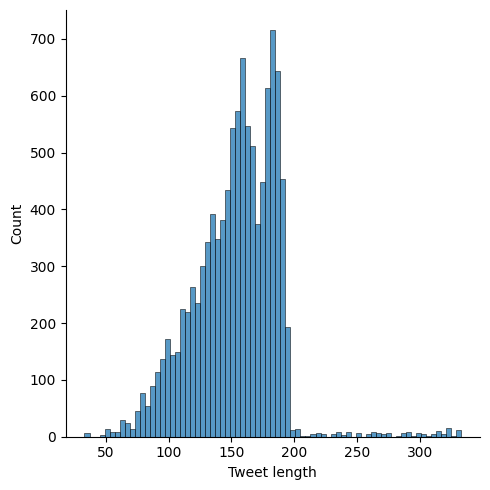

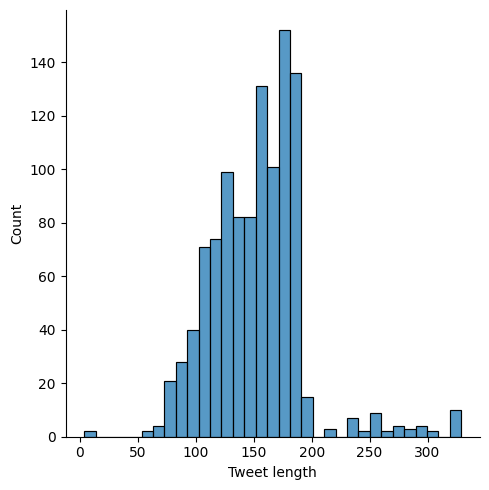

In [4]:
train['Tweet length'] = train.Tweet.apply(len)
sns.displot(train, x='Tweet length')

dev['Tweet length'] = dev.Tweet.apply(len)
sns.displot(dev, x='Tweet length')

train = train.drop(['Tweet length'], axis=1)
dev = dev.drop(['Tweet length'], axis=1)

## Preprocessing

In [5]:
# method to search answer start index in tweet
def answer_index_in_document(answer_list, document):

    for answer_string_in_doc in answer_list:
        index = document.lower().find(answer_string_in_doc)
        if index != -1:
            return answer_string_in_doc, index
    return answer_list[0], -1

In [6]:
answer = []
for index, row in train.iterrows():
    answer_string, start_index = answer_index_in_document(row['Answer'], row['Tweet'])
    #delete rows
    if start_index==-1:
        train = train.drop(index)
    else:
        answer.append({'text': [answer_string], 'answer_start': [start_index]})

train['Answer'] = answer

answer = []
for index, row in dev.iterrows():
    answer_string, start_index = answer_index_in_document(row['Answer'], row['Tweet'])
    #delete rows
    if start_index==-1:
        dev = dev.drop(index)
    else:
        answer.append({'text': [answer_string], 'answer_start': [start_index]})

dev['Answer'] = answer

print(len(train))
print(len(dev))
train.head(10)

6152
849


,Question,Answer,Tweet,qid
0,at which school were first responders on the s...,"{'text': ['independence high school'], 'answer...","Our prayers are with the students, educators &...",0c871b7e5320d0816d5b2979d67c2649
3,what is up to us to keep doing?,"{'text': ['exploring'], 'answer_start': [94]}",Cassini showed us the beauty of Saturn. It rev...,e6e40c7aa9a94b6bab363812ea1918b0
4,where can you see girls doing that?,"{'text': ['at the bar'], 'answer_start': [63]}","Nicki your video was just you twerking, I see ...",44041dedd11431be77e4a4cf5a8d0276
6,kaine took hundreds of thousands of dollars in...,"{'text': ['gifts'], 'answer_start': [67]}",Is it the same Kaine that took hundreds of tho...,64816a176b245200cc9ebd480775bfe7
7,who say he's gay because he watches rupaul's d...,"{'text': ['andrew garfield'], 'answer_start': ...",Andrew Garfield says he's gay because he watch...,724505d2deb93dd32ee0e49662e35536
8,what kind of contract did he have?,"{'text': ['a non-guaranteed contract'], 'answe...",The Cavs have released Edy Tavares. No surpris...,a75c45c89e478073dfd2a078487460a3
13,who is she celebrating?,"{'text': ['caitlyn'], 'answer_start': [16]}",Let's celebrate Caitlyn & use her moment to up...,0b7832644d7495c056877dd193c830f8
14,what is the hashtag in this post?,"{'text': ['#rupertsfault'], 'answer_start': [54]}",All Christian militia people and anyone they'v...,87ccb8fe67bd910a37d7b049705b0f34
15,who do we need more men like?,"{'text': ['drake'], 'answer_start': [22]}",We need more men like Drake who will call out ...,52cf3948e68a8824ea5a055add2e0160
18,what does trump wanted voted for,"{'text': ['graham-cassidy'], 'answer_start': [...",I hope Republican Senators will vote for Graha...,9a20806e083c073a1372bd331139fb15


In [7]:
train = Dataset.from_pandas(train)
train = train.remove_columns("__index_level_0__")

dev = Dataset.from_pandas(dev)
dev = dev.remove_columns("__index_level_0__")

data = DatasetDict({'train': train, 'dev': dev})
data

DatasetDict({
    train: Dataset({
        features: ['Question', 'Answer', 'Tweet', 'qid'],
        num_rows: 6152
    })
    dev: Dataset({
        features: ['Question', 'Answer', 'Tweet', 'qid'],
        num_rows: 849
    })
})

In [8]:
data['train'][0]

{'Question': 'at which school were first responders on the scene for?',
 'Answer': {'answer_start': [59], 'text': ['independence high school']},
 'Tweet': 'Our prayers are with the students, educators & families at Independence High School & all the first responders on the scene. #PatriotPride— Doug Ducey (@dougducey) February 12, 2016',
 'qid': '0c871b7e5320d0816d5b2979d67c2649'}

In [9]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

def preprocess_function(examples):
    
    questions = [q.strip() for q in examples["Question"]]
    inputs = tokenizer(
        questions,
        examples["Tweet"],
        max_length=200,
        truncation="only_second",
        return_offsets_mapping=True,
        padding="max_length",
    )

    offset_mapping = inputs.pop("offset_mapping")
    answers = examples["Answer"]
    start_positions = []
    end_positions = []

    for i, offset in enumerate(offset_mapping):
        answer = answers[i]
        start_char = answer["answer_start"][0]
        end_char = answer["answer_start"][0] + len(answer["text"][0])
        sequence_ids = inputs.sequence_ids(i)

        # Find the start and end of the context
        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1

        # If the answer is not fully inside the context, label it (0, 0)
        if offset[context_start][0] > end_char or offset[context_end][1] < start_char:
            start_positions.append(0)
            end_positions.append(0)
        else:
            # Otherwise it's the start and end token positions
            idx = context_start
            while idx <= context_end and offset[idx][0] <= start_char:
                idx += 1
            start_positions.append(idx - 1)

            idx = context_end
            while idx >= context_start and offset[idx][1] >= end_char:
                idx -= 1
            end_positions.append(idx + 1)

    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions

    return inputs

In [10]:
tokenized_data = data.map(preprocess_function, batched=True, remove_columns=data["train"].column_names)

Map:   0%|          | 0/6152 [00:00<?, ? examples/s]

Map:   0%|          | 0/849 [00:00<?, ? examples/s]

## Training

In [13]:
model = AutoModelForQuestionAnswering.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForQuestionAnswering: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased a

In [14]:
data_collator = DefaultDataCollator()

training_args = TrainingArguments(
    output_dir="training_BERT_model",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_data["train"],
    eval_dataset=tokenized_data["dev"],
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer.train()
trainer.save_model(DATA_PATH+"BERT_base_model")

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,No log,1.505581
2,No log,1.228679
3,1.474200,1.197558


## Evaluation

In [15]:
#model = AutoModelForQuestionAnswering.from_pretrained('BERT_base_model')
question_answerering = pipeline("question-answering", model=model, tokenizer=tokenizer, device=0)

predictions = {'qid':[], 'Answer':[]}
for each in data['dev']:
    result = question_answerering(question=each['Question'], context=each['Tweet'])
    predictions['qid'].append(each['qid'])
    predictions['Answer'].append(result['answer'])

predictions = pd.DataFrame(predictions)
predictions.head(10)

/usr/local/lib/python3.9/dist-packages/transformers/pipelines/base.py:1070: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


,qid,Answer
0,f867d1c3361549952be5639ca433895f,NJ
1,f1c214d65d1cd73b457c1dba09f90013,Quick turns. Narrow.
2,c1b8f64f3e38a33b80a8c575f1ce902c,#endangeredriver
3,c5e6eb7f974409ac4561fd1c2ba0fb58,MONSTARS BASKETBALL @M0NSTARSBBALLWiggins
4,2a926fe0bbebd143a1cbc4d942bb3fcb,106-106. 8.9
5,8afe79edb832cb15ffc4fd88f27fc1d4,106-106. 8.9
6,26ba00ae731854015da139515ed0d033,Kemba
7,bfe50582de9a45aa047f155ba9ca3334,CNN
8,9c7b6346cd5446c195657f33a4b02eef,Tsonga
9,b06bc7f7e91ba15ae1d7a08187e7647d,ahead of his first match in the #DavisCupFinal


In [16]:
predictions.to_json(DATA_PATH+'BERT_base_predictions.json', orient='records')